<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/BIGGAN_birds_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gan tensorflow-addons imageio -q
!rm -rf sample_data BigGANUtils checkpoints samples
!mkdir checkpoints samples
!git clone https://github.com/xarvel/BigGANUtils.git

Cloning into 'BigGANUtils'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 119 (delta 76), reused 68 (delta 29), pack-reused 0
Receiving objects: 100% (119/119), 34.93 MiB | 10.34 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [ ]:
import tensorflow.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, ReLU,  BatchNormalization, Reshape, Embedding
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import time
from IPython import display
import numpy as np
from tqdm import tqdm 
import imageio
import glob
import IPython
import math
from BigGANUtils.SelfAttention import SelfAttention
from BigGANUtils.GBlock import GBlock
from BigGANUtils.DBlock import DBlock
from BigGANUtils.SpectralNormalization import SpectralNormalization
from BigGANUtils.ConditionalBatchNormalization import ConditionalBatchNormalization
from BigGANUtils.SNDense import SNDense 
from BigGANUtils.SNConv2D import SNConv2D
from BigGANUtils.SNEmbedding import SNEmbedding

print(tf.__version__)

2.9.2


In [ ]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
#@title CONFIG

IMAGE_SIZE = 256
IMAGE_CHANNELS = 3
DATASET_SIZE = 13262
BUFFER_SIZE = DATASET_SIZE
PER_REPILICA_BATCH_SIZE = 8
GLOBAL_BATCH_SIZE = PER_REPILICA_BATCH_SIZE * strategy.num_replicas_in_sync
EPOCHS = 30
LATENT_DIM = 126
CHECKPOINT_DIR = 'checkpoints'
SAMPLES_DIR = 'samples'
CHECKPOINT_INTERVAL = 5
SEED = 1
NUM_CLASSES = 100
TFRECORD_PATH = 'gs://brids-xarvel/*.tfrec'
SAMPLE_INTERVAL = 1

GAN_FILTERS = 64
GENERATOR_LR = 0.0001
DISCRIMINATOR_LR = 0.0004
ADAM_BETA_1 = 0.0
ADAM_BETA_2 = 0.99
ADAM_EPSILON = 1e-07

In [ ]:
tf.random.set_seed(SEED)

weight_initializer = 'orthogonal' 

# weight_initializer = tf.keras.initializers.RandomNormal(
#     mean=0.0, stddev=0.02, seed=SEED
# )

In [ ]:
#@title Dataset

def preprocess_image(img):
    return tf.cast(img, tf.float32) / 127.5 - 1.

def get_tfrecord_dataset(
    batch_size: int,
    tfrecord_path: str,
    is_training: bool,
    *,
    image_size: int,
):
    def parse_example(proto):
        features = {
          "image": tf.io.FixedLenFeature([], tf.string), 
          'height': tf.io.FixedLenFeature([], tf.int64),
          'width': tf.io.FixedLenFeature([], tf.int64),
          'channels': tf.io.FixedLenFeature([], tf.int64),
          'label_text': tf.io.FixedLenFeature([], tf.string), 
          'label_onehot':  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
          'label_number': tf.io.FixedLenFeature([], tf.int64),
        }

        parsed = tf.io.parse_single_example(
            serialized=proto,
            features=features
        )

        image, label = parsed["image"], parsed["label_number"]
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (image_size, image_size))
    
        return image, label

    def augment(image, label):
      image = tf.image.random_flip_left_right(
          image, seed=SEED
      )

      return image, label  
    
    tfrecord_files = tf.io.gfile.glob(tfrecord_path)

    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_example)
    
    if is_training:
      dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True, seed=SEED)
      dataset = dataset.repeat()
      dataset = dataset.map(augment)

    dataset = dataset.map(lambda image, label: (preprocess_image(image), label))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
   
    return dataset

train_dataset = get_tfrecord_dataset(
    batch_size=GLOBAL_BATCH_SIZE,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=False
) 

In [ ]:
#@title Generator

class Generator(Model):
  def __init__(self, channels, num_classes, embedding_size):
    super(Generator, self).__init__()
    self.channels = channels
    self.linear = SNDense(4 * 4 * 16 * channels, use_bias=False, kernel_initializer=weight_initializer)
    self.reshape = Reshape([4, 4, 16 * channels])

    self.res_block_1 = GBlock(16 * channels, kernel_initializer=weight_initializer)
    self.res_block_2 = GBlock(8 * channels, kernel_initializer=weight_initializer)
    self.res_block_3 = GBlock(8 * channels, kernel_initializer=weight_initializer)
    self.res_block_4 = GBlock(4 * channels, kernel_initializer=weight_initializer)
    self.res_block_5 = GBlock(2 * channels, kernel_initializer=weight_initializer)
    self.attention = SelfAttention(kernel_initializer=weight_initializer)
    self.res_block_6 = GBlock(channels, kernel_initializer=weight_initializer)

    self.embedding = Embedding(num_classes, embedding_size, embeddings_initializer=weight_initializer)

    self.bn = BatchNormalization()
    self.activation = ReLU()
    self.conv = SNConv2D(filters=IMAGE_CHANNELS, kernel_size=3, padding='same', kernel_initializer=weight_initializer)
    self.concat = Concatenate();

  @tf.function
  def call(self, z, label, training=False):    
    z_split = tf.split(z, num_or_size_splits=7, axis=-1)
    embed = self.embedding(label)
    conds = [self.concat([z_i, embed]) for z_i in z_split[1:]]
    x = self.linear(z_split[0], training=training)
    x = self.reshape(x)
    x = self.res_block_1(x, conds[0], training=training)
    x = self.res_block_2(x, conds[1], training=training)
    x = self.res_block_3(x, conds[2], training=training)
    x = self.res_block_4(x, conds[3], training=training)
    x = self.res_block_5(x, conds[4], training=training)
    x = self.attention(x, training=training)
    x = self.res_block_6(x, conds[5], training=training)
    x = self.bn(x, training=training)
    x = self.activation(x)
    x = self.conv(x, training=training)
    return tf.nn.tanh(x)


In [ ]:
#@title Discriminator

class Discriminator(Model):
  def __init__(self, channels, num_classes):
    super(Discriminator, self).__init__()
    self.res_block_1 = DBlock(1 * channels, downsample=True, preactivation=False,  kernel_initializer=weight_initializer)
    self.res_block_2 = DBlock(2 * channels, downsample=True, preactivation=True, kernel_initializer=weight_initializer)
    self.res_block_3 = DBlock(4 * channels, downsample=True, preactivation=True, kernel_initializer=weight_initializer)
    self.res_block_4 = DBlock(8 * channels, downsample=True, preactivation=True, kernel_initializer=weight_initializer)
    self.res_block_5 = DBlock(8 * channels, downsample=True, preactivation=True, kernel_initializer=weight_initializer)
    self.res_block_6 = DBlock(16 * channels, downsample=True, preactivation=True, kernel_initializer=weight_initializer)
    self.attention = SelfAttention(kernel_initializer=weight_initializer)
    self.res_block_7 = DBlock(16 * channels, downsample=False, preactivation=True, kernel_initializer=weight_initializer)
    self.activation = ReLU()
    self.embedding = SNEmbedding(num_classes, 16 * channels, embeddings_initializer=weight_initializer)
    self.linear = SNDense(1, kernel_initializer=weight_initializer)
  
  @tf.function
  def call(self, x, label, training=False):
    x = self.res_block_1(x, training=training)
    x = self.res_block_2(x, training=training)
    x = self.res_block_3(x, training=training)
    x = self.res_block_4(x, training=training)
    x = self.res_block_5(x, training=training)
    x = self.res_block_6(x, training=training)
    x = self.attention(x, training=training)
    x = self.res_block_7(x, training=training)
    x = self.activation(x)
    x = tf.reduce_sum(x, axis=[1, 2])
    out = self.linear(x, training=training)
    embed = self.embedding(label)
    out += tf.reduce_sum(x * embed, axis=-1, keepdims=True)
    return out

In [ ]:
with strategy.scope():
  generator = Generator(GAN_FILTERS, num_classes=NUM_CLASSES, embedding_size=LATENT_DIM)
  discriminator = Discriminator(GAN_FILTERS, num_classes=NUM_CLASSES)

In [ ]:
train_dataset = strategy.distribute_datasets_from_function(
    lambda _: get_tfrecord_dataset(
    batch_size=PER_REPILICA_BATCH_SIZE,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=True
))

In [ ]:
hinge = tf.keras.losses.Hinge(reduction=tf.keras.losses.Reduction.NONE)

def discriminator_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor :
  real_loss = hinge(tf.ones_like(logits_real), logits_real)
  fake_loss = hinge(tf.zeros_like(logits_fake), logits_fake)
  total_loss = real_loss + fake_loss

  return tf.nn.compute_average_loss(total_loss, global_batch_size=GLOBAL_BATCH_SIZE)

def generator_loss(logits_fake: tf.Tensor) -> tf.Tensor:
  loss = hinge(tf.ones_like(logits_fake), logits_fake)
  return tf.nn.compute_average_loss(loss, global_batch_size=GLOBAL_BATCH_SIZE)


In [ ]:
with strategy.scope():
  generator_optimizer = Adam(
      learning_rate=GENERATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2,
      epsilon=ADAM_EPSILON
  )
  discriminator_optimizer = Adam(
      learning_rate=DISCRIMINATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2, 
      epsilon=ADAM_EPSILON
  )

In [ ]:
import random

fixed_noise = tf.random.truncated_normal((NUM_CLASSES, LATENT_DIM), stddev=1)

def sample_single_image():
  label = tf.constant([random.randint(0, 10)])
  noise = tf.random.truncated_normal([1, LATENT_DIM], stddev=0.5)
  generated_image = generator(noise, label, training=False)
  plt.imshow(generated_image[0] * 0.5 + 0.5)  

def sample_images(epoch=0, save=False, show=True):
  square_size = int(math.sqrt(NUM_CLASSES))
  rows = square_size
  cols = square_size
  noise = fixed_noise

  labels = np.arange(0, NUM_CLASSES)
  gen_imgs = generator(noise, labels)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  fig.subplots_adjust(
      wspace = 0.0,
      hspace = 0.0
  )
  px = 1/plt.rcParams['figure.dpi']

  fig.set_figheight(IMAGE_SIZE * rows * px)
  fig.set_figwidth(IMAGE_SIZE * cols * px)

  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[j * square_size + i])
  
      axs[i,j].axis('off')

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(SAMPLES_DIR, exist_ok=True)

  if save:
    plt.savefig(SAMPLES_DIR + '/image_at_epoch_{:04d}.png'.format(epoch))
    
  if show:
    plt.show()
  else:
    plt.close(fig)

def sample_analytics(meta, save=False, show=True):
  history = meta['history']

  with plt.xkcd():
    fig, axs = plt.subplots(figsize=(10,10))
    plt.plot(history['gen_loss'], label='Generator loss')
    plt.plot(history['disc_loss'], label='Discriminator loss')
    plt.title('Learing process')
    
    plt.figtext(.7, .17, '\n'.join([
        'Epoch=%s' % meta['epoch'],
        "GEN_LR=%s" % GENERATOR_LR,
        'DISC_LR=%s' % DISCRIMINATOR_LR,
        'FILTERS=%s' % GAN_FILTERS,
        'PER_REPILICA_BATCH_SIZE=%s' % PER_REPILICA_BATCH_SIZE
    ]))

    fig.legend();

    if save:
      fig.savefig(SAMPLES_DIR + '/analytics_at_epoch_{:04d}.png'.format(meta['epoch'])) 
  
    if show:   
      plt.show()
    else:
      plt.close(fig)

In [ ]:
#@title checkpoint
import json

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")
latest_checkpoint = tf.train.latest_checkpoint(CHECKPOINT_DIR)

defaultMeta = {
    "history": {
        "disc_loss": [],
        "gen_loss": []
    },
    "epoch": 1
}
meta = defaultMeta

META_FILE = CHECKPOINT_DIR + '/meta.json'

def restore_checkpoint():
  try:
    with open(META_FILE) as f:
      meta = json.load(f)
  except:
    meta = defaultMeta
    pass
  
  status = checkpoint.restore(latest_checkpoint, options=local_device_option)
  return meta

def save_checkpoint():
  print('Saving checkpoint');

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

  with open(META_FILE, 'w') as f:
    json.dump(meta, f)
  
  checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
  checkpoint.save(file_prefix = checkpoint_prefix, options=local_device_option)

meta = restore_checkpoint();

(1, 256, 256, 3)


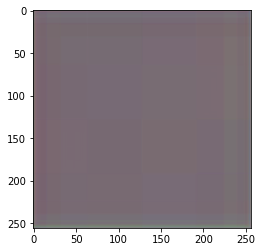

In [ ]:
with strategy.scope():
  label = tf.constant([1])
  noise = tf.random.truncated_normal([1, LATENT_DIM], stddev=0.5)
  generated_image = generator(noise, label, training=False)
  print(generated_image.shape)
  plt.imshow(generated_image[0] * 0.5 + 0.5)  

In [ ]:
with strategy.scope():
  decision = discriminator(generated_image, label)
  print(decision)

tf.Tensor([[0.7118281]], shape=(1, 1), dtype=float32)


In [ ]:
#@title train_step

with strategy.scope():
  d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
  g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

@tf.function
def train_step(iterator):
  """The step function for one training step."""

  def step_fn(inputs):
    """The computation to run on each TPU device."""
    images, labels = inputs
    noise = tf.random.normal([PER_REPILICA_BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, labels, training=True)
      gen_predictions = discriminator(generated_images, labels, training=True)
      real_predictions = discriminator(images, labels, training=True)
      disc_loss = discriminator_loss(real_predictions, gen_predictions)
      gen_loss = generator_loss(gen_predictions)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
    discriminator_optimizer.apply_gradients(
      zip(gradients_of_discriminator, discriminator.trainable_weights)
    )
    
    d_loss_metric.update_state(disc_loss)
    g_loss_metric.update_state(gen_loss)
    
    return disc_loss, gen_loss

  disc_loss, gen_loss = strategy.run(step_fn, args=(next(iterator),))

  disc_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, disc_loss, axis=None)
  gen_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, gen_loss, axis=None)
  
  return disc_loss, gen_loss

In [21]:
steps_per_epoch = DATASET_SIZE // PER_REPILICA_BATCH_SIZE
train_iterator = iter(train_dataset)

for epoch in range(meta['epoch'], EPOCHS + 1):
  meta['epoch'] = epoch
  start = time.time()
  print('Epoch: {}/{}'.format(epoch, EPOCHS))

  pbar = tqdm(range(steps_per_epoch))
  for step in pbar:
    disc_loss, gen_loss = train_step(train_iterator)
    meta['history']['disc_loss'].append(float(disc_loss));
    meta['history']['gen_loss'].append(float(gen_loss));
    pbar.set_postfix({'disc_loss': round(float(disc_loss), 4), 'gen_loss': round(float(gen_loss), 4)})
    pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())

  if epoch % SAMPLE_INTERVAL == 0:
    sample_images(epoch, save=True, show=False)
    
  if epoch % CHECKPOINT_INTERVAL == 0:
    save_checkpoint()
    sample_analytics(meta, save=True, show=False)   

  print('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

Epoch: 1/30


  0%|          | 0/1657 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall_1:2", shape=(8,), dtype=int64), values=Tensor("PartitionedCall_1:1", shape=(8, 126), dtype=float32), dense_shape=Tensor("PartitionedCall_1:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
Current step 1657: 100%|██████████| 1657/1657 [20:09<00:00,  1.37it/s, disc_loss=0.0197, gen_loss=0.381]


Time for epoch 1 is 1233.6989715099335 sec
Epoch: 2/30


Current step 3314: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0089, gen_loss=0.398]


Time for epoch 2 is 736.5194582939148 sec
Epoch: 3/30


Current step 4971: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0146, gen_loss=0.56]


Time for epoch 3 is 736.4211058616638 sec
Epoch: 4/30


Current step 6628: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0438, gen_loss=0.35]


Time for epoch 4 is 736.0320839881897 sec
Epoch: 5/30


Current step 8285: 100%|██████████| 1657/1657 [11:56<00:00,  2.31it/s, disc_loss=0.0246, gen_loss=0.553]


Saving checkpoint
Time for epoch 5 is 747.9996371269226 sec
Epoch: 6/30


Current step 9942: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0047, gen_loss=0.423]


Time for epoch 6 is 737.333788394928 sec
Epoch: 7/30


Current step 11599: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0246, gen_loss=0.361]


Time for epoch 7 is 737.6743831634521 sec
Epoch: 8/30


Current step 13256: 100%|██████████| 1657/1657 [11:56<00:00,  2.31it/s, disc_loss=0.0054, gen_loss=0.475]


Time for epoch 8 is 736.455418586731 sec
Epoch: 9/30


Current step 14913: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0077, gen_loss=0.372]


Time for epoch 9 is 736.5922243595123 sec
Epoch: 10/30


Current step 16570: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0061, gen_loss=0.464]


Saving checkpoint
Time for epoch 10 is 743.7092266082764 sec
Epoch: 11/30


Current step 18227: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0171, gen_loss=0.554]


Time for epoch 11 is 738.565826177597 sec
Epoch: 12/30


Current step 19884: 100%|██████████| 1657/1657 [11:56<00:00,  2.31it/s, disc_loss=0.0636, gen_loss=0.281]


Time for epoch 12 is 736.0683350563049 sec
Epoch: 13/30


Current step 21541: 100%|██████████| 1657/1657 [11:56<00:00,  2.31it/s, disc_loss=0.0111, gen_loss=0.445]


Time for epoch 13 is 735.6449587345123 sec
Epoch: 14/30


Current step 23198: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0117, gen_loss=0.427]


Time for epoch 14 is 736.3620944023132 sec
Epoch: 15/30


Current step 24855: 100%|██████████| 1657/1657 [11:56<00:00,  2.31it/s, disc_loss=0.0255, gen_loss=0.363]


Saving checkpoint
Time for epoch 15 is 744.0709972381592 sec
Epoch: 16/30


Current step 26512: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0258, gen_loss=0.41]


Time for epoch 16 is 737.1061577796936 sec
Epoch: 17/30


Current step 28169: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0624, gen_loss=0.57]


Time for epoch 17 is 737.5719110965729 sec
Epoch: 18/30


Current step 29826: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0585, gen_loss=0.499]


Time for epoch 18 is 736.9986388683319 sec
Epoch: 19/30


Current step 31483: 100%|██████████| 1657/1657 [11:56<00:00,  2.31it/s, disc_loss=0.0275, gen_loss=0.443]


Time for epoch 19 is 740.5999364852905 sec
Epoch: 20/30


Current step 33140: 100%|██████████| 1657/1657 [11:56<00:00,  2.31it/s, disc_loss=0.103, gen_loss=0.58]


Saving checkpoint
Time for epoch 20 is 744.2545096874237 sec
Epoch: 21/30


Current step 34797: 100%|██████████| 1657/1657 [11:56<00:00,  2.31it/s, disc_loss=0.0219, gen_loss=0.438]


Time for epoch 21 is 736.3453915119171 sec
Epoch: 22/30


Current step 36454: 100%|██████████| 1657/1657 [11:56<00:00,  2.31it/s, disc_loss=0.0303, gen_loss=0.425]


Time for epoch 22 is 735.888087272644 sec
Epoch: 23/30


Current step 38111: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0512, gen_loss=0.529]


Time for epoch 23 is 736.1601538658142 sec
Epoch: 24/30


Current step 39768: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0456, gen_loss=0.301]


Time for epoch 24 is 736.6365659236908 sec
Epoch: 25/30


Current step 41425: 100%|██████████| 1657/1657 [11:57<00:00,  2.31it/s, disc_loss=0.0266, gen_loss=0.396]


Saving checkpoint
Time for epoch 25 is 744.6022510528564 sec
Epoch: 26/30


Current step 41765:  21%|██        | 340/1657 [02:27<09:31,  2.31it/s, disc_loss=0.0304, gen_loss=0.397]


KeyboardInterrupt: ignored

In [ ]:
sample_analytics(meta, save=False, show=True)    

In [ ]:
sample_images(meta['epoch'], save=False, show=True)

In [ ]:
samples = SAMPLES_DIR + '/samples.gif'

with imageio.get_writer(samples, mode='I') as writer:
  filenames = glob.glob(SAMPLES_DIR + '/image_at_epoch_*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
IPython.display.Image(filename=samples, embed=True)

In [ ]:
sample_single_image()